In [1]:
import numpy as np
import sipm.sipm as sipm
import sipm.dataset as ds
import sipm.beta as beta
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sipm.constants as const
import ROOT
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Welcome to JupyROOT 6.26/06


In [2]:
!pwd

/home/as111/sipm-analysis


## Read SiPM pulse shape from csv

In [2]:
# import csv
# pulse_pars_top = []
# pulse_pars_bot = []
# with open('../pulse_parameters_65V.csv') as f:
#     r = csv.reader(f)
#     line_count = 0
#     for row in r:
#         if line_count>0:
#             if line_count<=4:
#                 pulse_pars_top.append([float(par) for par in row[1:]])
#                 print(pulse_pars_top[-1])
#             else:
#                 pulse_pars_bot.append([float(par) for par in row[1:]])
#                 print(pulse_pars_bot[-1])
#         line_count += 1

# pulse_pars_top = [  [4.729400842250102,0.2569877809951521,4.127761572790463,0.01960473296118813],
#                     [5.298939237028267,0.28606772865854035,6.054583189031878,0.007963468550868958],
#                     [1.3195771032746428,0.6181204448096527,5.194151979440704,0.1036681252331754],
#                     [1.6700923870720912,0.4960557462347394,4.922845851879696,0.07493697881927766]]
# pulse_pars_bot = [  [3.1103336463130233,0.40017855736066715,4.005918637901939,0.04715322583082441],
#                     [0.5290761403386268,1.2721845294668654,5.731619092673906,0.08616165425230965],
#                     [1.3806753235665463,0.7640468547891118,5.176028307869261,0.07842661877653297],
#                     [0.7700665901697702,1.0074408537247341,5.72977882434228,0.11422545852465689]]




# List of Datasets
- Bottom:
    * 11/07: 1-6, overnight
    * 11/09: high stat
    * 11/10: high stat, overnight (~11/13)
    * 11/14: gamma, backgrounds
    
- Top:
    * 11/08: 0, overnight
    * 11/09: high stat
    * 11/10: high stat
    * 11/14: gamma, backgrounds

# 11/15 Top Bottom with Backgrounds

In [3]:
ds1120 = []
pos = ['top', 'bottom']
for i in range(2):
    data = ds.Dataset(path='', mode='', channels=range(4))
    file = ROOT.TFile('root/gamma_71V_{}.root'.format(pos[i]), 'read')
    for ch in range(4):
        gwf = file.Get("gScintWf_ch{}".format(ch))
        data.ch[ch].scint_avgwf = list(gwf.GetY())
        data.ch[ch].time = list(gwf.GetX())
    ds1120.append(data)

1588
ch0 A_S=1.58+/-0.05  TAU_S=0.0149+/-0.0007us  A_T=0.12+/-0.00  TAU_T=1.279+/-0.054us sigma=0.0032+/-0.0002us t0=6.279+/-0.000us
1590
ch1 A_S=1.86+/-0.10  TAU_S=0.0173+/-0.0012us  A_T=0.15+/-0.01  TAU_T=1.344+/-0.092us sigma=0.0033+/-0.0004us t0=6.287+/-0.000us
1588
ch2 A_S=1.60+/-0.05  TAU_S=0.0169+/-0.0007us  A_T=0.14+/-0.00  TAU_T=1.270+/-0.053us sigma=0.0031+/-0.0002us t0=6.279+/-0.000us
1589
ch3 A_S=1.80+/-0.08  TAU_S=0.0133+/-0.0008us  A_T=0.14+/-0.01  TAU_T=1.253+/-0.063us sigma=0.0029+/-0.0003us t0=6.283+/-0.000us
1590
ch0 A_S=4.16+/-0.18  TAU_S=0.0190+/-0.0011us  A_T=0.33+/-0.01  TAU_T=1.475+/-0.081us sigma=0.0039+/-0.0003us t0=6.289+/-0.000us
1590
ch1 A_S=3.97+/-0.19  TAU_S=0.0178+/-0.0011us  A_T=0.34+/-0.01  TAU_T=1.547+/-0.083us sigma=0.0035+/-0.0003us t0=6.288+/-0.000us
1588
ch2 A_S=5.32+/-0.16  TAU_S=0.0182+/-0.0007us  A_T=0.42+/-0.01  TAU_T=1.588+/-0.061us sigma=0.0033+/-0.0002us t0=6.281+/-0.000us
1590
ch3 A_S=4.89+/-0.16  TAU_S=0.0208+/-0.0009us  A_T=0.41+/-0.01  T

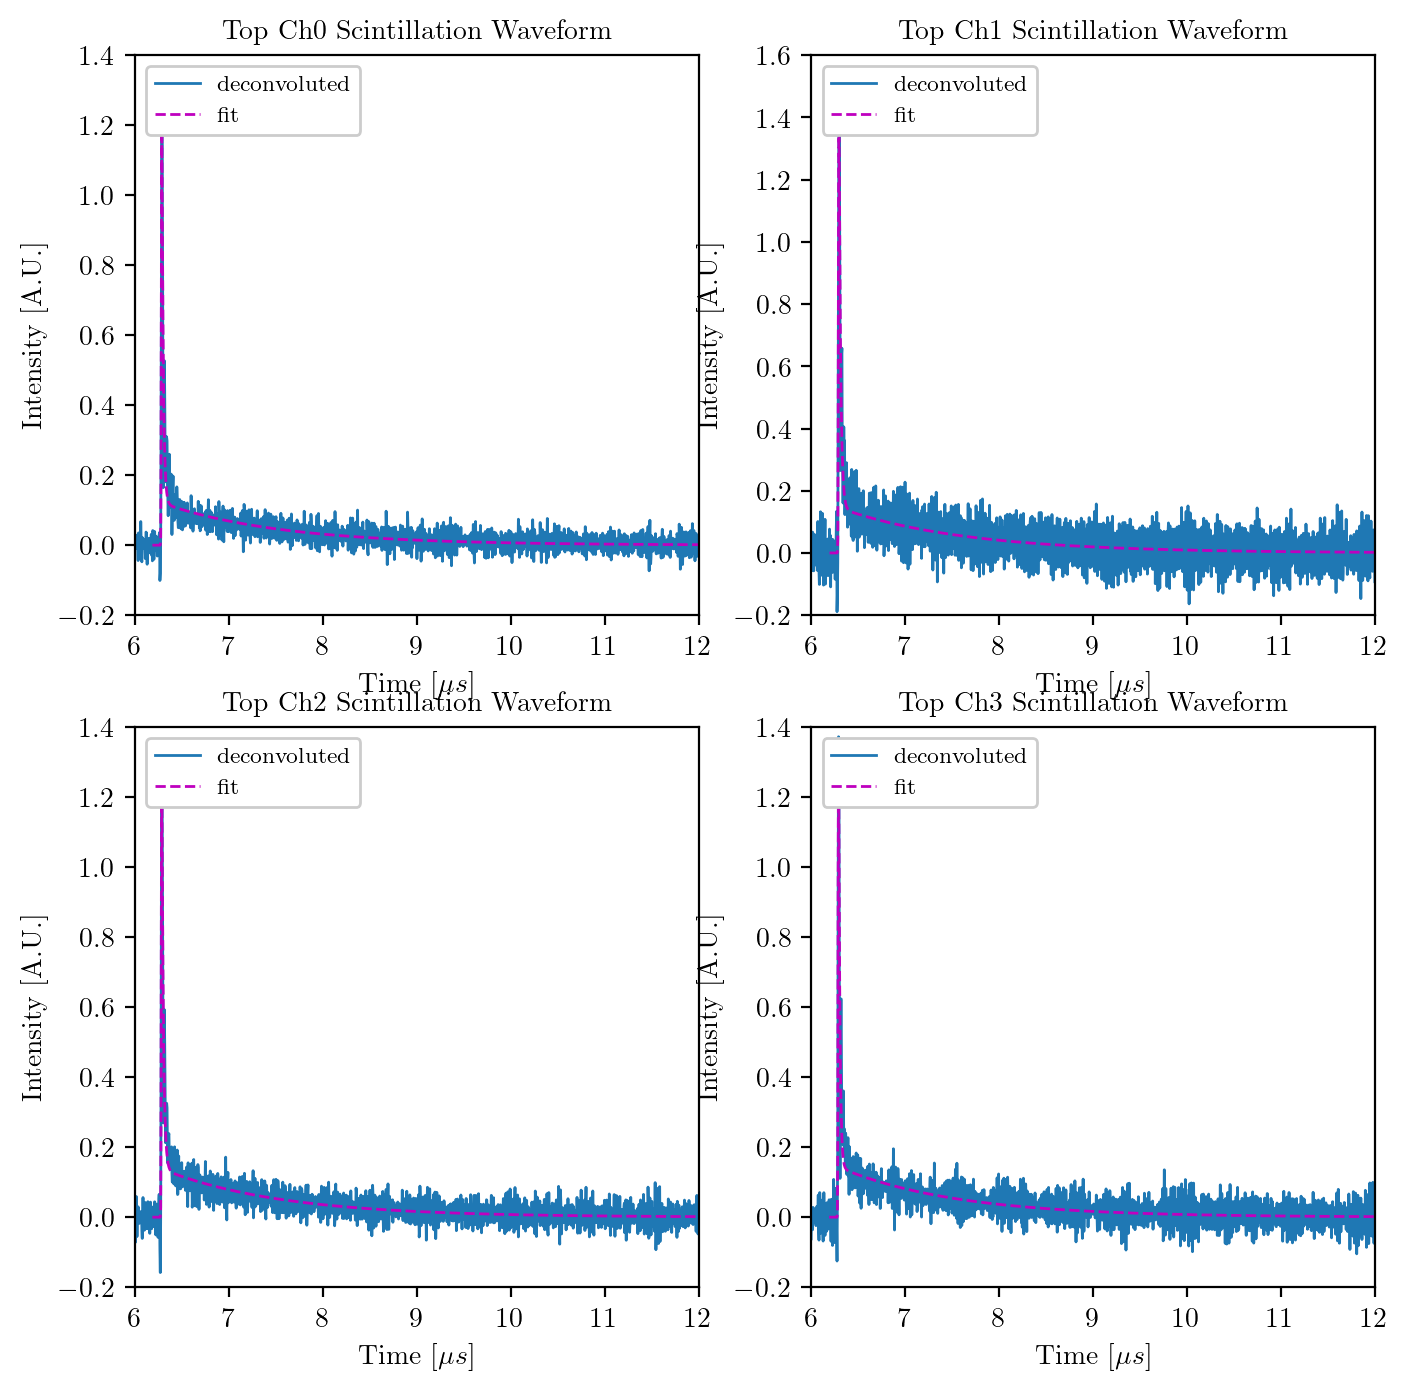

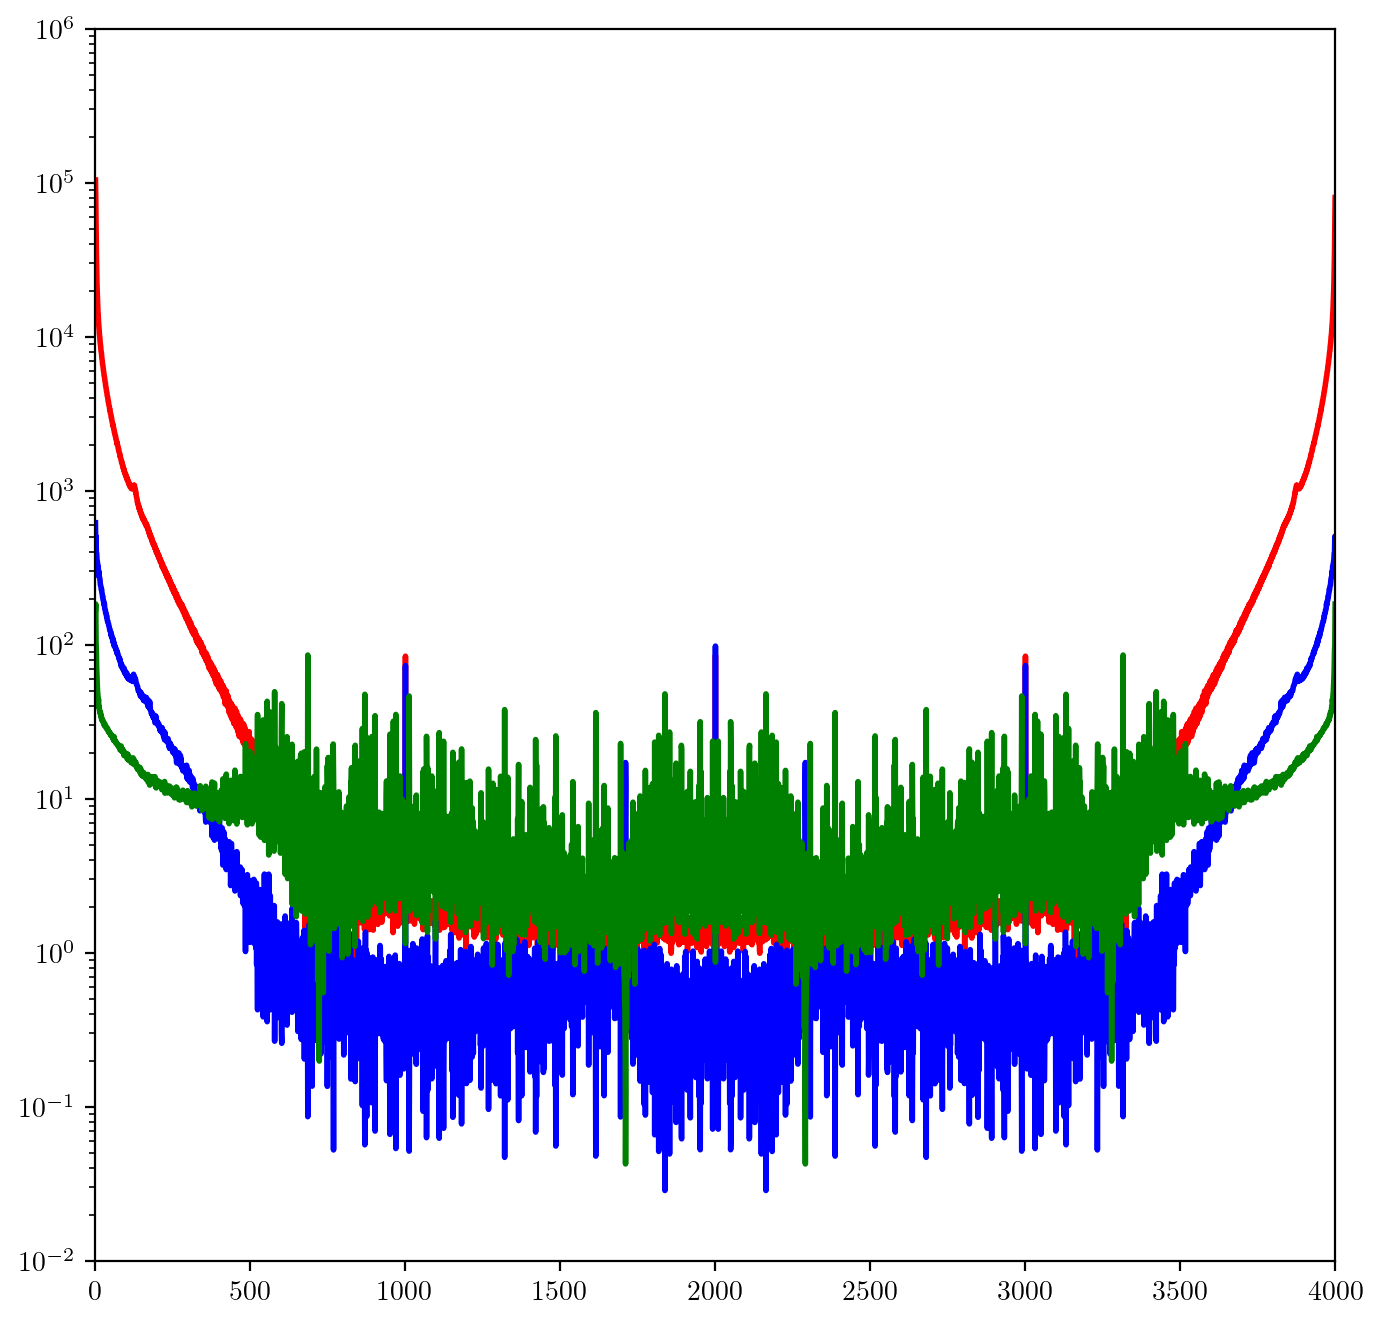

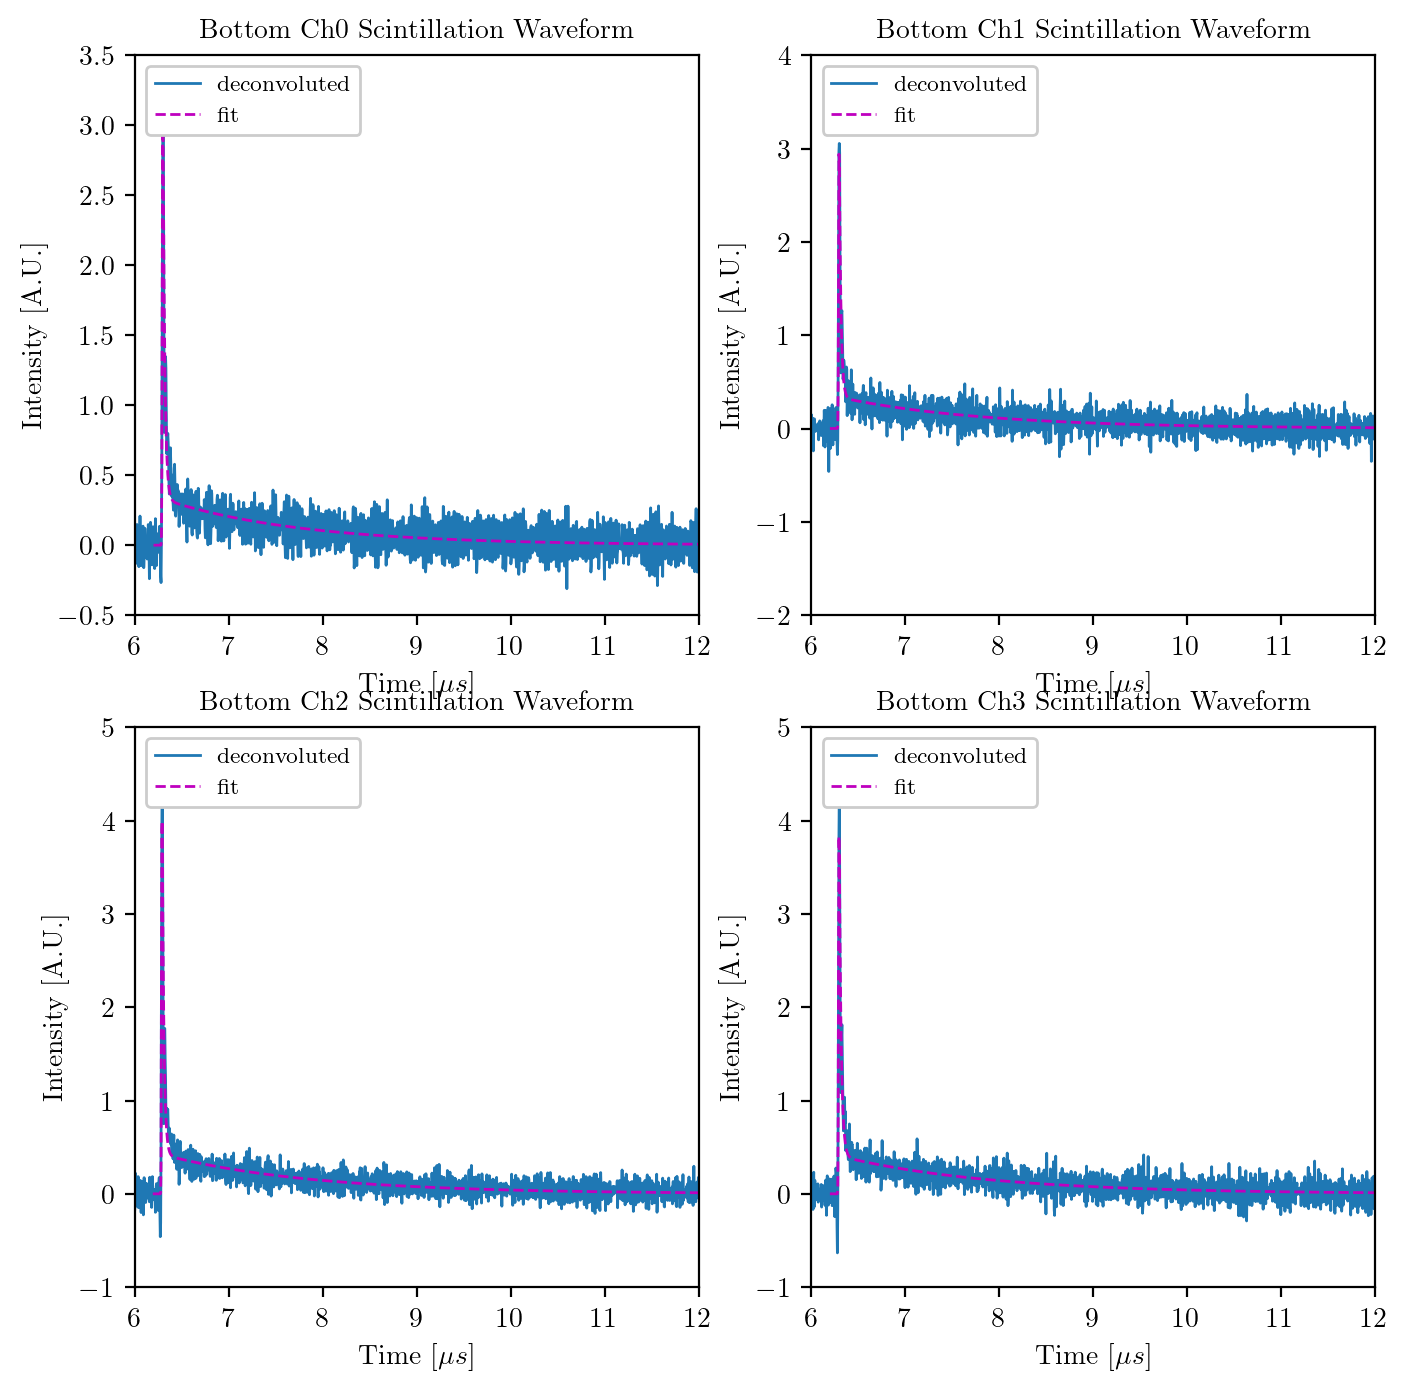

In [4]:
from scipy.fft import fft, ifft
import ROOT
f_deconv_sum = []
position = ['Top', 'Bottom']
for i in range(2):
    dset = ds1120[i]
    plt.figure(i,figsize=(8,8))
    f_deconv_sum_pos = np.zeros(len(dset.ch[0].time))
    file = None
    if i==0:
        file = ROOT.TFile('root/SPE_waveform_1122_71V_top.root', 'read')
    else:
        file = ROOT.TFile('root/SPE_waveform_1122_71V_bottom.root', 'read')
    for ch in range(4):
#         if i==0:
#             dset.ch[ch].set_pulse_pars(*pulse_pars_top[ch])
#         else:
#             dset.ch[ch].set_pulse_pars(*pulse_pars_bot[ch])
        
        ftilde = fft(dset.ch[ch].scint_avgwf)
        
#         a1,tau1,a2,tau2 = dset.ch[ch].get_pulse_pars()
#         h = lambda x: a1*np.exp(-x/tau1)+a2*np.exp(-x/tau2)
#         htilde = fft(h(dset.ch[ch].time))
        gSPE = file.Get('gSPE_ch{}'.format(ch))
        spe_wf = np.array(list(gSPE.GetY()))
        tpeak = np.argmax(spe_wf)
        print(tpeak)
        htilde = fft(spe_wf)
        for f in range(len(htilde)):
            htilde[f] *= np.exp(complex(0,2*np.pi*f*tpeak/spe_wf.size))
        f_deconv = ifft(ftilde/htilde).real
        if ch==3 and i==1:
            plt.figure(2*(i+1), figsize=(8,8))
            plt.plot(abs(ftilde),'r')
            plt.plot(abs(htilde),'b')
            plt.plot(abs(ftilde/htilde), 'g')
            plt.yscale('log')
        plt.figure(i,figsize=(8,8))
        f_deconv_sum_pos += f_deconv
        t0 = np.argmax(f_deconv)-int(0.1/dset.ch[ch].sample_step)
        length = int(6/dset.ch[ch].sample_step)
        dset.ch[ch].baseline_samples = tpeak-50
        err = np.std(dset.ch[ch].scint_avgwf[:dset.ch[ch].baseline_samples])
        popt,pcov = curve_fit(dset.ch[ch].get_scintillation, dset.ch[ch].time[t0:t0+length], f_deconv[t0:t0+length], p0=[1, 0.02, 0.1, 1.2, 0.01, 6.25], sigma=[err]*length, maxfev=100000)
        print('ch{} A_S={:.2f}+/-{:.2f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.2f}+/-{:.2f}  TAU_T={:.3f}+/-{:.3f}us sigma={:.4f}+/-{:.4f}us t0={:.3f}+/-{:.3f}us'.format(ch,popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
        dset.ch[ch].tau_singlet = [popt[1], np.sqrt(pcov[1,1])]
        dset.ch[ch].tau_triplet = [popt[3], np.sqrt(pcov[3,3])]
        plt.subplot(2,2,ch+1)
        plt.plot(dset.ch[ch].time, f_deconv, label='deconvoluted', linewidth=1)
        plt.plot(dset.ch[ch].time[t0:t0+length], dset.ch[ch].get_scintillation(dset.ch[ch].time[t0:t0+length], *popt), "m--", label='fit', linewidth=1)
        plt.title('{} Ch{} Scintillation Waveform'.format(position[i],ch))
        plt.ylabel('Intensity [A.U.]')
        plt.xlabel(r'Time [$\mu s$]')
        plt.legend()
        plt.xlim(6,12)
    f_deconv_sum.append(f_deconv_sum_pos)

Top A_S=5.5938+/-0.1366  TAU_S=0.0206+/-0.0007us  A_T=0.5210+/-0.0124  TAU_T=1.3562+/-0.0433us sigma=0.0035+/-0.0002us t0=6.2812+/-0.0002us
Bottom A_S=16.0811+/-0.3436  TAU_S=0.0226+/-0.0006us  A_T=1.4532+/-0.0295  TAU_T=1.6079+/-0.0446us sigma=0.0040+/-0.0002us t0=6.2854+/-0.0002us


Text(0.5, 0.98, '1120 Data 71V')

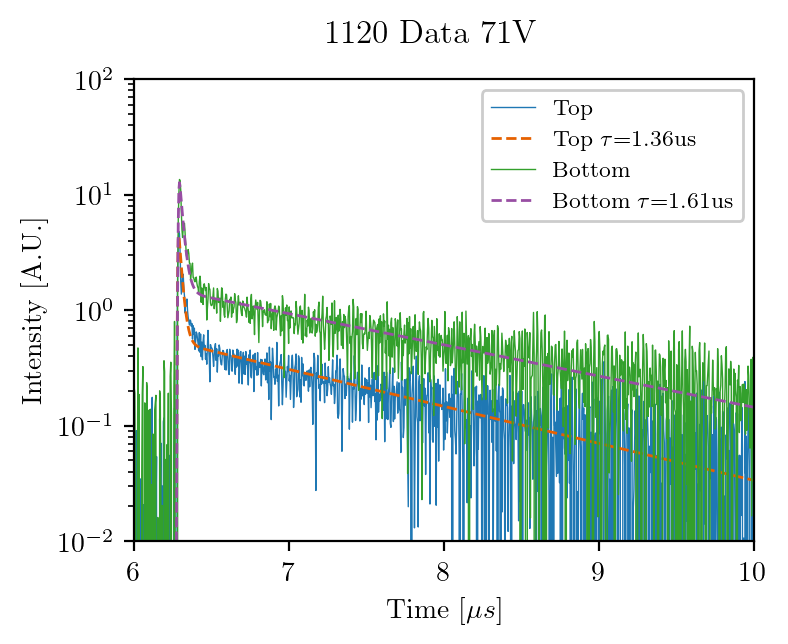

In [5]:
tau_triplet_1120 = []
labels = ['Top','Bottom']
for i,fdc in enumerate(f_deconv_sum):
    dset = ds1120[i].ch[0]
    t0 = np.argmax(fdc)+int(-0.05/dset.sample_step)
    length = int(5/dset.sample_step)
    err = np.std(fdc[:dset.baseline_samples])
    popt,pcov = curve_fit(dset.get_scintillation, dset.time[t0:t0+length], fdc[t0:t0+length], p0=[5, 0.02, 0.5, 1.2, 0.01, 6.25], sigma=[err]*length, maxfev=100000)
    print('{} A_S={:.4f}+/-{:.4f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.4f}+/-{:.4f}  TAU_T={:.4f}+/-{:.4f}us sigma={:.4f}+/-{:.4f}us t0={:.4f}+/-{:.4f}us'.format(labels[i],popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
    tau_triplet_1120.append([popt[3], np.sqrt(pcov[3,3])])
    plt.plot(dset.time, fdc, '-', label=labels[i], linewidth=0.5)
    plt.plot(dset.time[t0:t0+length], dset.get_scintillation(dset.time[t0:t0+length], *popt), '--', label=r'{} $\tau$={:.2f}us'.format(labels[i], popt[3]), linewidth=1)
    
plt.legend(loc='upper right')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel('Intensity [A.U.]')
plt.yscale('log')
plt.xlim(6, 10)
plt.ylim(1e-2, 1e2)
plt.suptitle('1120 Data 71V')

# Bottom 11/07 11/09 11/10 Day

In [3]:
# subdir: 0-9
dir1107bot = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/2022-11-07_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_purification_1/'
#subdir: 0-19
dir1109bot = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_high_stat/'
#subdir: 0-19
dir1110bot = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_bottom_light_scintillation_coinc_111_cond_gamma_high_stat/'

In [4]:
ds_bot = []
nsubdir = [10,20,20]
# gain = [[T0,T1,T2,T3],[B0,B1,B2,B3]]
# gain = [[526.15408, 519.05546, 507.44070, 521.98428], [518.84503, 510.84132, 504.40531, 457.59589]]
#dir1107bot, dir1109bot
for i,dir in enumerate([dir1110bot]):
    for j in range(20):
        subdir = '{}{}/'.format(dir, j)
        print(subdir)
        data = ds.Dataset(subdir, pol=-1, channels=range(4), spe=[1,1,1,1])
        for ch in range(4):
            data.ch[ch].set_pulse_pars(*pulse_pars_bot[ch])
            data.ch[ch].path = subdir
            data.ch[ch].read_data()
            data.ch[ch].baseline_subtraction()
            data.ch[ch].deconvolution()
            data.ch[ch].get_integral(prompt=0.1, long=5, deconv=True)
            data.ch[ch].get_avgwf(integral_range=[5*data.gain[ch], 100*data.gain[ch]])
            data.ch[ch].clear()
    data.get_summed_integral_pe()
    data.get_fprompt()
    ds_bot.append(data)

/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_bottom_light_scintillation_coinc_111_cond_gamma_high_stat/0/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_bottom_light_scintillation_coinc_111_cond_gamma_high_stat/1/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_bottom_light_scintillation_coinc_111_cond_gamma_high_stat/2/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_bottom_light_scintillation_coinc_111_cond_gamma_high_stat/3/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_bottom_light_scintillation_coinc_111_cond_gamma_high_stat/4/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_bottom_light_scintillation_coinc_111_cond_gamma_high_stat/5/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_bottom_light_scintillation_coinc_111_co

<Figure size 800x600 with 0 Axes>

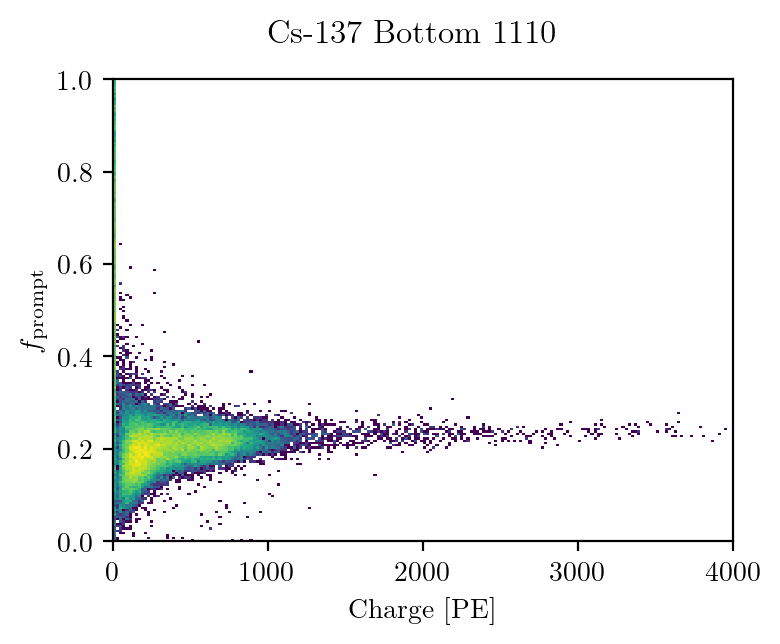

<Figure size 800x600 with 0 Axes>

In [5]:
import matplotlib.colors as colors
plt.figure(0)
dset = ds_bot[0]
plt.hist2d(dset.summed_integral_pe, dset.fprompt, bins=[200,200], range=[[0,4000],[0,1]], norm = colors.LogNorm())
plt.xlabel('Charge [PE]')
plt.ylabel(r'$f_{\rm prompt}$')
plt.suptitle('Cs-137 Bottom 1110')
plt.figure(1)

## Triplet lifetime evolution

(0.8, 2.0)

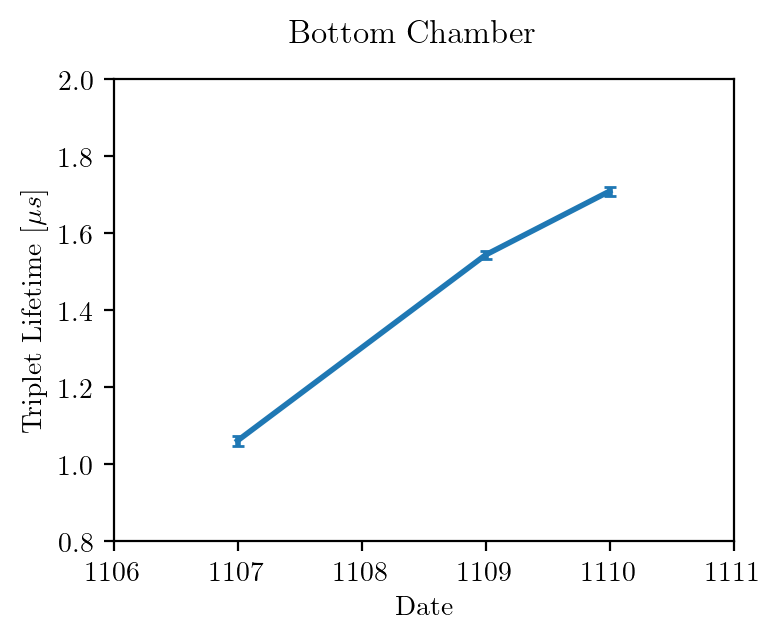

In [62]:
date_bot = [1107, 1109, 1110]
tau_triplet_bot = np.array(tau_triplet_bot)
plt.errorbar(date_bot, tau_triplet_bot[:,0], yerr=tau_triplet_bot[:,1])
plt.xlim(1106, 1111)
plt.xlabel('Date')
plt.ylabel(r'Triplet Lifetime [$\mu s$]')
plt.suptitle('Bottom Chamber')
plt.ylim(0.8, 2.0)

# Bottom 11/10-11/13

In [3]:
# subdir: 0-19
dir1110bot_on = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_overnight/'

In [4]:
ds1110bot_on = []
# gain = [[T0,T1,T2,T3],[B0,B1,B2,B3]]
gain = [[526.15408, 519.05546, 507.44070, 521.98428], [518.84503, 510.84132, 504.40531, 457.59589]]
for j in range(20):
    subdir = '{}{}/'.format(dir1110bot_on, j)
    print(subdir)
    data = ds.Dataset('', pol=-1, channels=range(4), spe=gain[1])
    for ch in range(4):
        data.ch[ch].set_pulse_pars(*pulse_pars_bot[ch])
        data.ch[ch].path = subdir
        data.ch[ch].read_data()
        data.ch[ch].baseline_subtraction()
        data.ch[ch].get_integral(prompt=0.5, long=5)
        data.ch[ch].clear()
    data.get_summed_integral_pe()
    data.get_fprompt()
    data.get_avgwf_all(count=-1, integral_range=(100,800), fprompt_range=(0.2,0.35))
    ds1110bot_on.append(data)

/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_overnight/0/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_overnight/1/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_overnight/2/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_overnight/3/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_overnight/4/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_overnight/5/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_bottom_li

In [18]:
from scipy.fft import fft, ifft
f_deconv_sum = []
# plt.figure(0,figsize=(8,8))
temp = pulse_pars_bot[2]
pulse_pars_bot[2] = pulse_pars_bot[3]
pulse_pars_bot[3] = temp
for i,dset in enumerate(ds1110bot_on):
    f_deconv_sum_i = np.zeros(dset.ch[0].samples)
    for ch in [0,2,3]:
        print(i,ch)
        dset.ch[ch].set_pulse_pars(*pulse_pars_bot[ch])
        ftilde = fft(dset.ch[ch].avgwf)
        a1,tau1,a2,tau2 = dset.ch[ch].get_pulse_pars()
        h = lambda x: a1*np.exp(-x/tau1)+a2*np.exp(-x/tau2)
        htilde = fft(h(dset.ch[ch].time))
        f_deconv = ifft(ftilde/htilde).real
        f_deconv_sum_i += f_deconv
        t0 = np.argmax(f_deconv)-int(0.1/dset.ch[ch].sample_step)
        length = int(6/dset.ch[ch].sample_step)
        err = np.std(dset.ch[ch].avgwf[:dset.ch[ch].baseline_samples])
        popt,pcov = curve_fit(dset.ch[ch].get_scintillation, dset.ch[ch].time[t0:t0+length], f_deconv[t0:t0+length], p0=[1, 0.02, 0.1, 1.2, 0.01, 6.25], sigma=[err]*length, maxfev=100000)
        print('ch{} A_S={:.2f}+/-{:.2f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.2f}+/-{:.2f}  TAU_T={:.3f}+/-{:.3f}us sigma={:.4f}+/-{:.4f}us t0={:.3f}+/-{:.3f}us'.format(ch,popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
        dset.ch[ch].tau_singlet = [popt[1], np.sqrt(pcov[1,1])]
        dset.ch[ch].tau_triplet = [popt[3], np.sqrt(pcov[3,3])]
        # plt.subplot(2,2,ch+1)
        # plt.plot(dset.ch[ch].time, f_deconv, label='deconvoluted', linewidth=1)
        # plt.plot(dset.ch[ch].time[t0:t0+length], dset.ch[ch].get_scintillation(dset.ch[ch].time[t0:t0+length], *popt), "m--", label='fit', linewidth=1)
        # plt.title('{} Ch{} Scintillation Waveform'.format(date[i],ch))
        # plt.ylabel('Intensity [A.U.]')
        # plt.xlabel(r'Time [$\mu s$]')
        # plt.legend()
        # # plt.yscale('log')
        # plt.ylim(1e-3, 1e1)
        # plt.ylim(-0.05,0.2)
        # plt.xlim(6,12)
    f_deconv_sum.append(f_deconv_sum_i)

0 0
ch0 A_S=2.10+/-0.02  TAU_S=0.0316+/-0.0004us  A_T=0.23+/-0.00  TAU_T=1.318+/-0.014us sigma=0.0080+/-0.0001us t0=6.259+/-0.000us
0 2
ch2 A_S=3.46+/-0.04  TAU_S=0.0213+/-0.0003us  A_T=0.45+/-0.00  TAU_T=1.281+/-0.008us sigma=0.0086+/-0.0001us t0=6.259+/-0.000us
0 3
ch3 A_S=2.86+/-0.03  TAU_S=0.0340+/-0.0005us  A_T=0.26+/-0.00  TAU_T=1.477+/-0.021us sigma=0.0079+/-0.0001us t0=6.258+/-0.000us
1 0
ch0 A_S=2.12+/-0.02  TAU_S=0.0312+/-0.0004us  A_T=0.23+/-0.00  TAU_T=1.329+/-0.013us sigma=0.0080+/-0.0001us t0=6.259+/-0.000us
1 2
ch2 A_S=3.48+/-0.04  TAU_S=0.0214+/-0.0003us  A_T=0.45+/-0.00  TAU_T=1.298+/-0.008us sigma=0.0087+/-0.0001us t0=6.259+/-0.000us
1 3
ch3 A_S=2.89+/-0.03  TAU_S=0.0338+/-0.0005us  A_T=0.26+/-0.00  TAU_T=1.498+/-0.021us sigma=0.0080+/-0.0001us t0=6.258+/-0.000us
2 0
ch0 A_S=2.13+/-0.02  TAU_S=0.0314+/-0.0004us  A_T=0.23+/-0.00  TAU_T=1.348+/-0.013us sigma=0.0080+/-0.0001us t0=6.259+/-0.000us
2 2
ch2 A_S=3.52+/-0.04  TAU_S=0.0216+/-0.0003us  A_T=0.46+/-0.00  TAU_T=1.3

0 A_S=0.4868+/-0.1509  TAU_S=0.0743+/-0.0118us  A_T=0.7321+/-0.0067  TAU_T=1.5301+/-0.0071us sigma=0.0519+/-0.0118us t0=6.4168+/-0.0119us
1 A_S=0.5256+/-0.1636  TAU_S=0.0698+/-0.0115us  A_T=0.7336+/-0.0059  TAU_T=1.5471+/-0.0071us sigma=0.0518+/-0.0110us t0=6.4200+/-0.0103us
2 A_S=0.5371+/-0.1668  TAU_S=0.0691+/-0.0115us  A_T=0.7477+/-0.0057  TAU_T=1.5644+/-0.0070us sigma=0.0524+/-0.0107us t0=6.4201+/-0.0098us
3 A_S=0.5243+/-0.1706  TAU_S=0.0701+/-0.0121us  A_T=0.7537+/-0.0062  TAU_T=1.5631+/-0.0072us sigma=0.0523+/-0.0114us t0=6.4192+/-0.0107us
4 A_S=0.5272+/-0.2219  TAU_S=0.0703+/-0.0153us  A_T=0.7535+/-0.0082  TAU_T=1.5781+/-0.0092us sigma=0.0523+/-0.0151us t0=6.4176+/-0.0146us
5 A_S=0.5259+/-0.1693  TAU_S=0.0715+/-0.0120us  A_T=0.7615+/-0.0063  TAU_T=1.5917+/-0.0070us sigma=0.0534+/-0.0117us t0=6.4168+/-0.0111us
6 A_S=0.5382+/-0.1429  TAU_S=0.0643+/-0.0093us  A_T=0.7441+/-0.0043  TAU_T=1.6009+/-0.0061us sigma=0.0485+/-0.0084us t0=6.4259+/-0.0073us
7 A_S=0.5539+/-0.1720  TAU_S=0.064

Text(0.5, 0.98, 'Bottom Chamber')

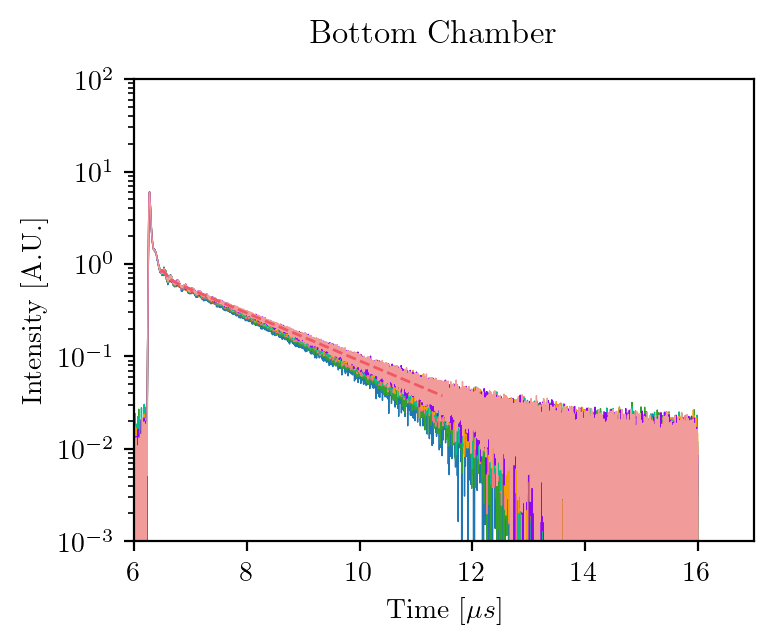

In [19]:
tau_triplet_1110on = []
for i,fdc in enumerate(f_deconv_sum):
    dset = ds1110bot_on[i].ch[0]
    t0 = np.argmax(fdc)+int(0.2/dset.sample_step)
    length = int(5/dset.sample_step)
    err = np.std(fdc[:dset.baseline_samples])
    popt,pcov = curve_fit(dset.get_scintillation, dset.time[t0:t0+length], fdc[t0:t0+length], p0=[5, 0.02, 0.5, 1.2, 0.01, 6.25], sigma=[err]*length, maxfev=100000)
    print('{} A_S={:.4f}+/-{:.4f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.4f}+/-{:.4f}  TAU_T={:.4f}+/-{:.4f}us sigma={:.4f}+/-{:.4f}us t0={:.4f}+/-{:.4f}us'.format(i,popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
    tau_triplet_1110on.append([popt[3], np.sqrt(pcov[3,3])])
    if i%3==0:
        plt.plot(dset.time, fdc, '-', label='{}'.format(i), linewidth=0.5)
        plt.plot(dset.time[t0:t0+length], dset.get_scintillation(dset.time[t0:t0+length], *popt), '--', label=r'{} $\tau$={:.2f}us'.format(i, popt[3]), linewidth=1)
    
# plt.legend(loc='upper right')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel('Intensity [A.U.]')
plt.yscale('log')
plt.xlim(6, 17)
plt.ylim(1e-3, 1e2)
plt.suptitle('Bottom Chamber')

(1.4, 2.0)

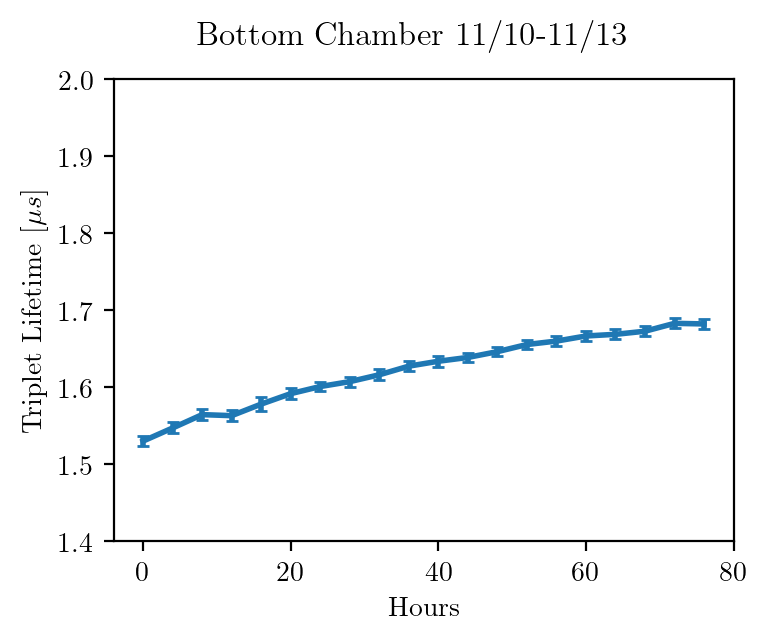

In [20]:
tau_triplet_1110on = np.array(tau_triplet_1110on)
plt.errorbar(np.arange(0,80,4), tau_triplet_1110on[:,0], yerr=tau_triplet_1110on[:,1])
plt.xlim(-4, 80)
plt.xlabel('Hours')
plt.ylabel(r'Triplet Lifetime [$\mu s$]')
plt.suptitle('Bottom Chamber 11/10-11/13')
plt.ylim(1.4, 2.0)

Text(0.5, 0.98, 'Bottom 1110 (4)')

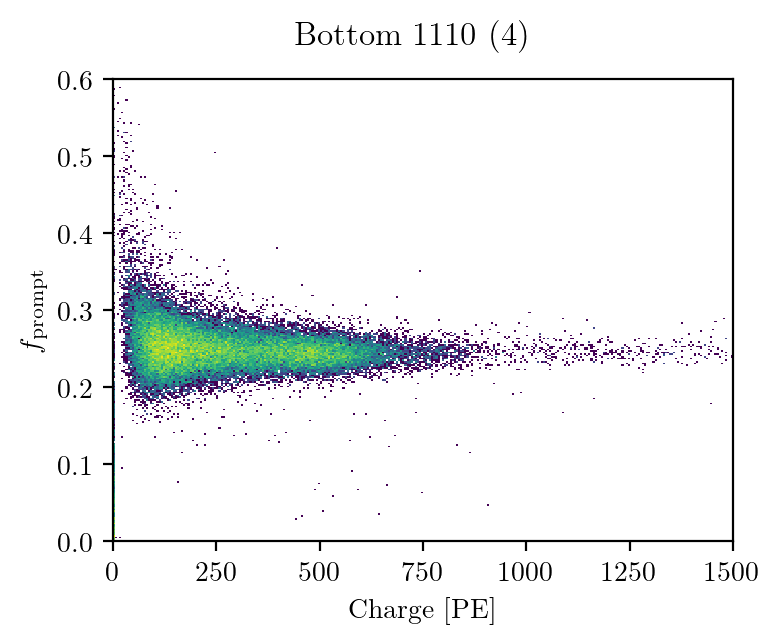

In [11]:
import matplotlib.colors as colors
plt.figure(0)
dset = ds1110bot_on[-1]
plt.hist2d(dset.summed_integral_pe, dset.fprompt, bins=[300,300], range=[[0,1500],[0,0.6]], norm = colors.LogNorm())
plt.xlabel('Charge [PE]')
plt.ylabel(r'$f_{\rm prompt}$')
plt.suptitle('Bottom 1110 (4)')

# Top 11/08 11/09 11/10 Day

In [32]:
# subdir: 0
dir1108top = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-08/2022-11-08_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_0/'
#subdir: 0-19
dir1109top = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/'
#subdir: 0-19
dir1110top = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/'

In [33]:
ds_top = []
nsubdir = [1,20,20]
# gain = [[T0,T1,T2,T3],[B0,B1,B2,B3]]
gain = [[526.15408, 519.05546, 507.44070, 521.98428], [518.84503, 510.84132, 504.40531, 457.59589]]
for i,dir in enumerate([dir1108top, dir1109top, dir1110top]):
    for j in range(nsubdir[i]):
        subdir = '{}{}/'.format(dir, j)
        print(subdir)
        data = ds.Dataset(subdir, pol=-1, channels=range(4), spe=gain[0])
        for ch in range(4):
            data.ch[ch].path = subdir
            data.ch[ch].read_data()
            data.ch[ch].baseline_subtraction()
            data.ch[ch].get_integral(prompt=0.5, long=5)
            data.ch[ch].get_avgwf(integral_range=[5*data.gain[ch], 100*data.gain[ch]])
            data.ch[ch].clear()
    data.get_summed_integral_pe()
    data.get_fprompt()
    ds_top.append(data)

/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-08/2022-11-08_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_0/0/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/0/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/1/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/2/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/3/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/4/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_top_light_scintillation_coinc_111_c

## Deconvolution channel by channel

ch0 A_S=0.67+/-0.02  TAU_S=0.0258+/-0.0009us  A_T=0.08+/-0.00  TAU_T=1.017+/-0.024us sigma=0.0110+/-0.0003us t0=6.248+/-0.000us
ch1 A_S=1.62+/-0.30  TAU_S=0.0095+/-0.0017us  A_T=0.18+/-0.00  TAU_T=0.559+/-0.013us sigma=0.0131+/-0.0006us t0=6.250+/-0.001us
ch2 A_S=0.73+/-0.02  TAU_S=0.0268+/-0.0007us  A_T=0.09+/-0.00  TAU_T=1.134+/-0.019us sigma=0.0105+/-0.0003us t0=6.246+/-0.000us
ch3 A_S=1.12+/-0.06  TAU_S=0.0145+/-0.0008us  A_T=0.04+/-0.00  TAU_T=1.598+/-0.043us sigma=0.0135+/-0.0003us t0=6.252+/-0.000us
ch0 A_S=0.68+/-0.02  TAU_S=0.0252+/-0.0010us  A_T=0.07+/-0.00  TAU_T=1.184+/-0.027us sigma=0.0107+/-0.0003us t0=6.248+/-0.000us
ch1 A_S=1.33+/-0.15  TAU_S=0.0120+/-0.0014us  A_T=0.17+/-0.00  TAU_T=0.668+/-0.014us sigma=0.0123+/-0.0005us t0=6.249+/-0.001us
ch2 A_S=0.74+/-0.02  TAU_S=0.0263+/-0.0007us  A_T=0.09+/-0.00  TAU_T=1.345+/-0.020us sigma=0.0104+/-0.0002us t0=6.247+/-0.000us
ch3 A_S=1.11+/-0.05  TAU_S=0.0144+/-0.0007us  A_T=0.04+/-0.00  TAU_T=1.819+/-0.041us sigma=0.0133+/-0.00

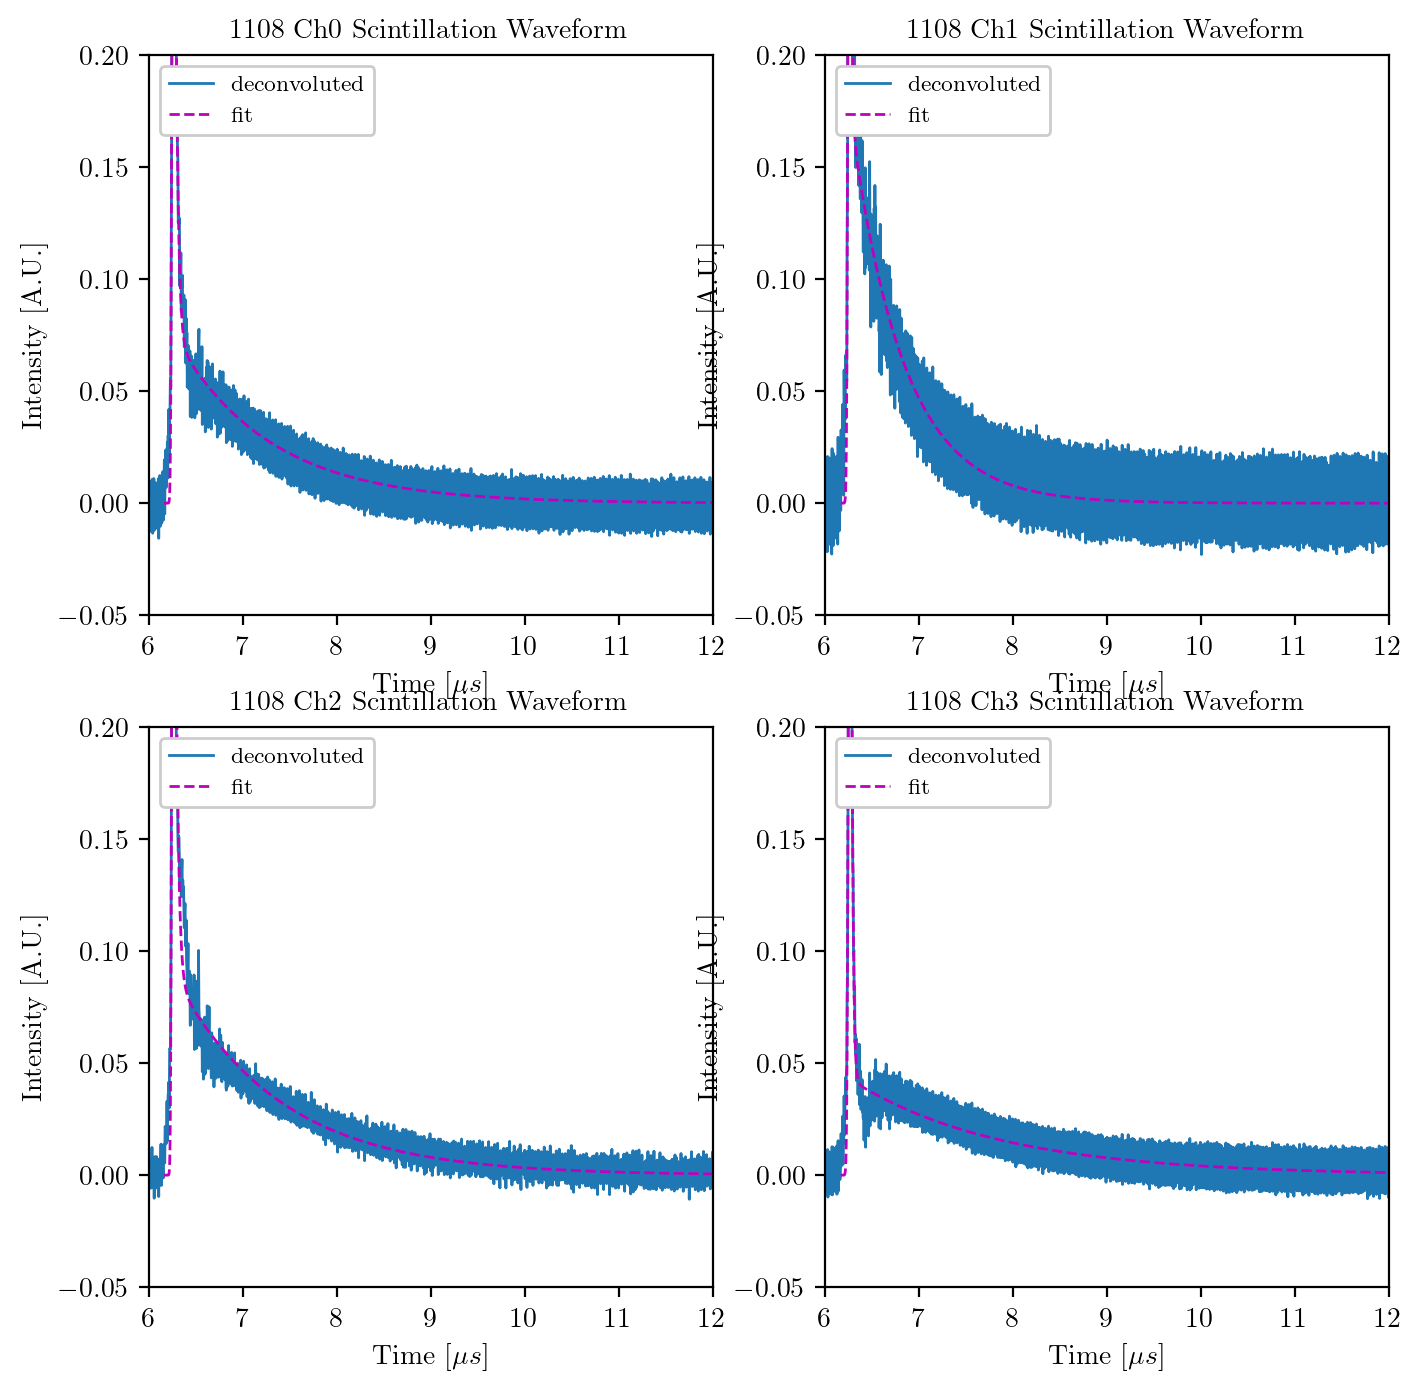

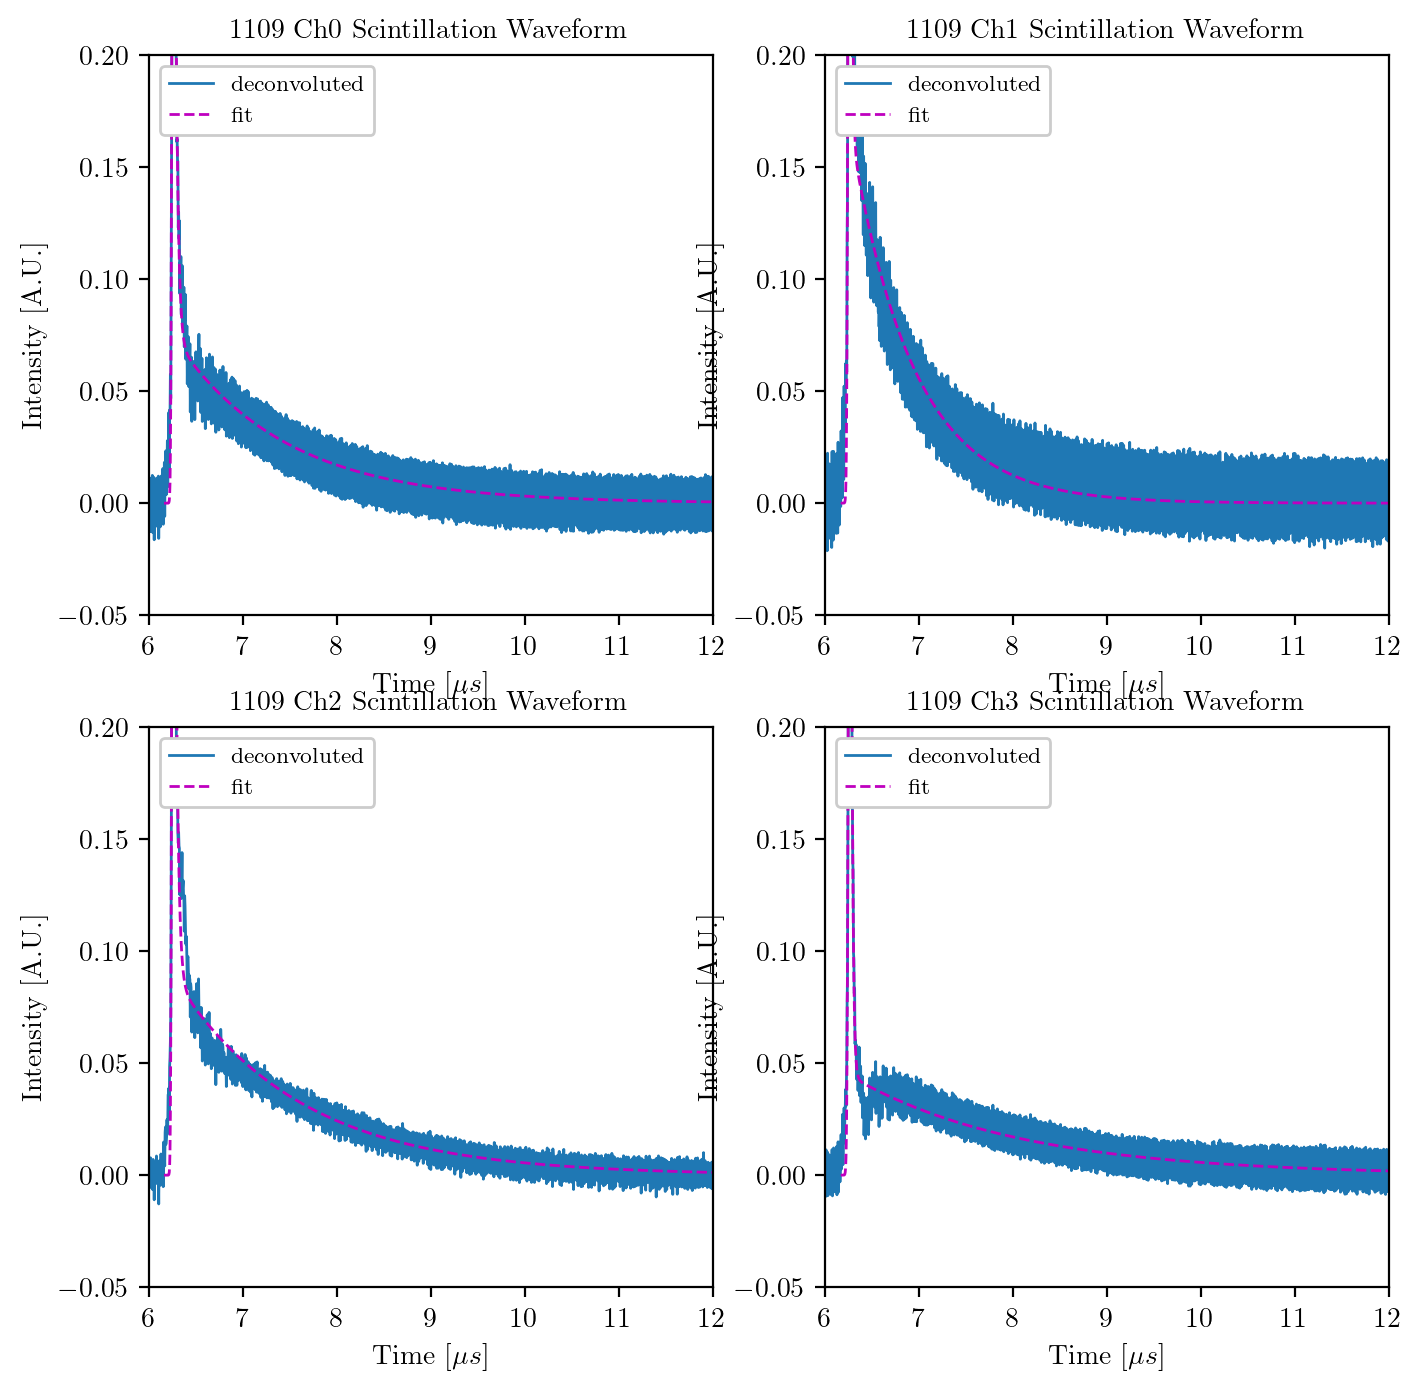

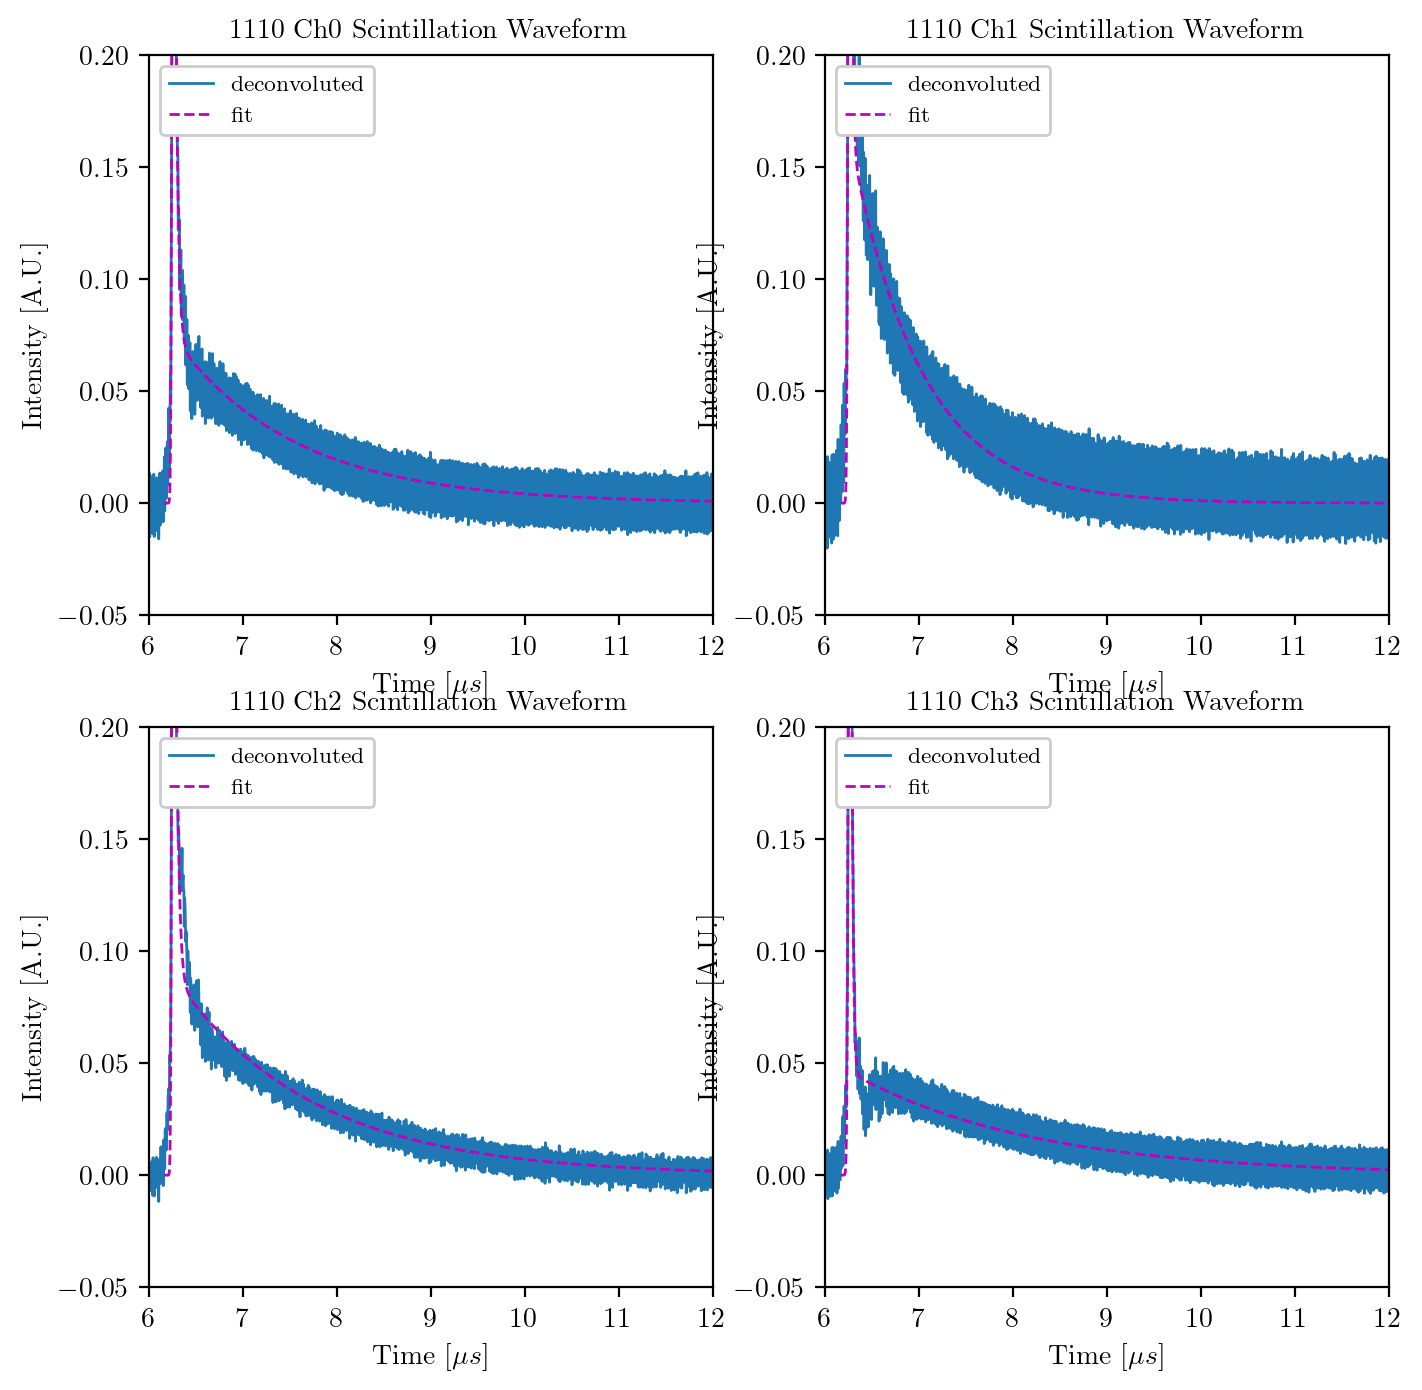

In [34]:
from scipy.fft import fft, ifft
f_deconv_sum_top = []
date = ['1108','1109','1110']
for i,dset in enumerate(ds_top):
    plt.figure(i,figsize=(8,8))
    f_deconv_sum_day = np.zeros(dset.ch[0].samples)
    for ch in range(4):
        dset.ch[ch].set_pulse_pars(*pulse_pars_top[ch])
        ftilde = fft(dset.ch[ch].avgwf)
        a1,tau1,a2,tau2 = dset.ch[ch].get_pulse_pars()
        h = lambda x: a1*np.exp(-x/tau1)+a2*np.exp(-x/tau2)
        htilde = fft(h(dset.ch[ch].time))
        f_deconv = ifft(ftilde/htilde).real
        f_deconv_sum_day += f_deconv
        t0 = np.argmax(f_deconv)-int(0.1/dset.ch[ch].sample_step)
        length = int(6/dset.ch[ch].sample_step)
        err = np.std(dset.ch[ch].avgwf[:dset.ch[ch].baseline_samples])
        popt,pcov = curve_fit(dset.ch[ch].get_scintillation, dset.ch[ch].time[t0:t0+length], f_deconv[t0:t0+length], p0=[1, 0.02, 0.1, 1.2, 0.01, 6.25], sigma=[err]*length, maxfev=100000)
        print('ch{} A_S={:.2f}+/-{:.2f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.2f}+/-{:.2f}  TAU_T={:.3f}+/-{:.3f}us sigma={:.4f}+/-{:.4f}us t0={:.3f}+/-{:.3f}us'.format(ch,popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
        dset.ch[ch].tau_singlet = [popt[1], np.sqrt(pcov[1,1])]
        dset.ch[ch].tau_triplet = [popt[3], np.sqrt(pcov[3,3])]
        plt.subplot(2,2,ch+1)
        plt.plot(dset.ch[ch].time, f_deconv, label='deconvoluted', linewidth=1)
        plt.plot(dset.ch[ch].time[t0:t0+length], dset.ch[ch].get_scintillation(dset.ch[ch].time[t0:t0+length], *popt), "m--", label='fit', linewidth=1)
        plt.title('{} Ch{} Scintillation Waveform'.format(date[i],ch))
        plt.ylabel('Intensity [A.U.]')
        plt.xlabel(r'Time [$\mu s$]')
        plt.legend()
        # plt.yscale('log')
        # plt.ylim(1e-3, 1e1)
        plt.ylim(-0.05,0.2)
        plt.xlim(6,12)
    f_deconv_sum_top.append(f_deconv_sum_day)

## Triplet lifetime evolution

Text(0.5, 0.98, 'Top Chamber')

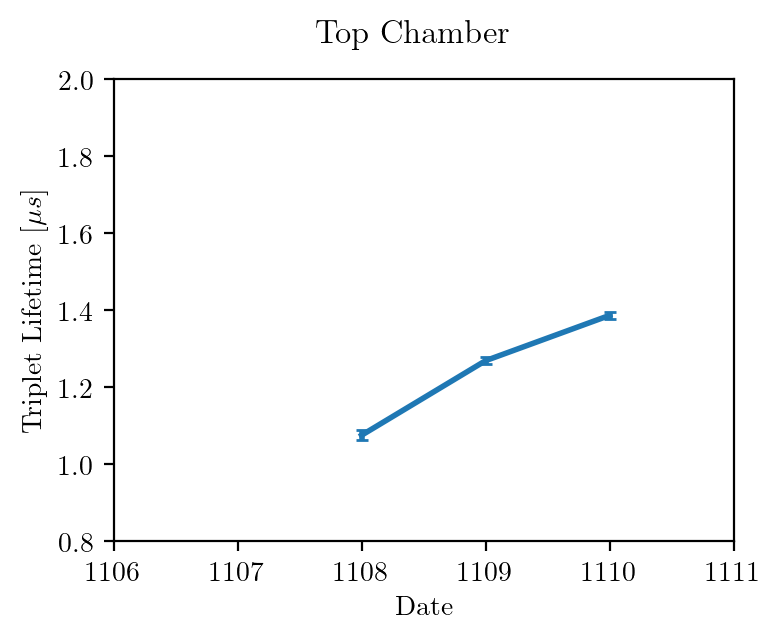

In [36]:
date_top = [1108, 1109, 1110]
tau_triplet_top = np.array(tau_triplet_top)
plt.errorbar(date_top, tau_triplet_top[:,0], yerr=tau_triplet_top[:,1])
plt.xlim(1106, 1111)
plt.xlabel('Date')
plt.ylabel(r'Triplet Lifetime [$\mu s$]')
plt.ylim(0.8, 2.0)
plt.suptitle('Top Chamber')

## Triplet lifetime evolution (Top vs Bottom)

(0.8, 2.0)

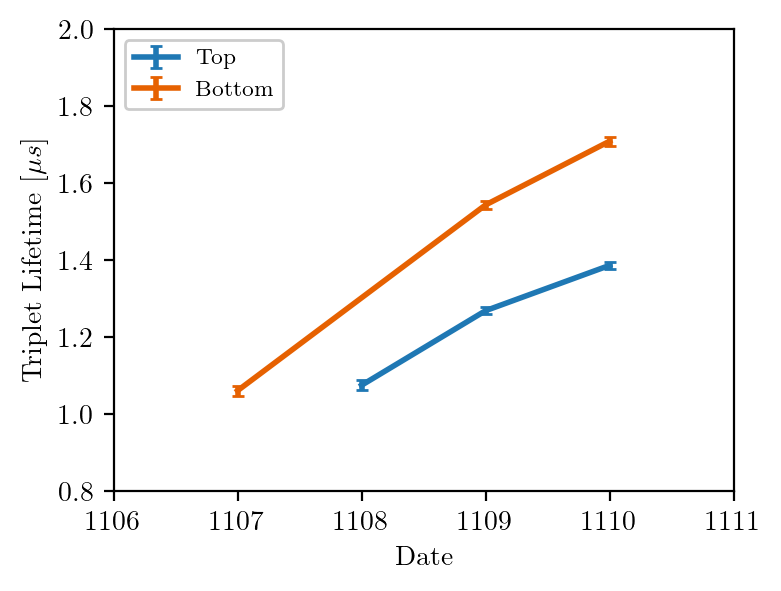

In [37]:
date_top = [1108, 1109, 1110]
tau_triplet_top = np.array(tau_triplet_top)
plt.errorbar(date_top, tau_triplet_top[:,0], yerr=tau_triplet_top[:,1], label='Top')
plt.errorbar(date_bot, tau_triplet_bot[:,0], yerr=tau_triplet_bot[:,1], label='Bottom')
plt.legend()
plt.xlim(1106, 1111)
plt.xlabel('Date')
plt.ylabel(r'Triplet Lifetime [$\mu s$]')
plt.ylim(0.8, 2.0)